# LowProFool
## Adversarial examples generation on the german credit dataset

### Imports

In [1]:
# Misc
import random
import numpy as np
import pandas as pd
import tqdm
from tqdm import tqdm
from tqdm import tqdm_notebook
import math
import os
import time
import sys

In [2]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Sklearn
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [4]:
# Pytorch
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
# Keras 
import keras

In [7]:
# Helpers
from Adverse import lowProFool, deepfool
from Metrics import *

### Notebook config

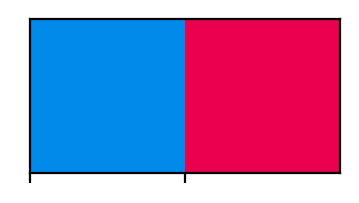

In [5]:
# Retina display
%config InlineBackend.figure_format ='retina'
pd.set_option('display.max_columns', 500)
tqdm.pandas()
np.set_printoptions(suppress=True)

%load_ext autoreload
%autoreload 2

ccolors = ["#008ae9", "#ea004f"]
sns.set_palette(ccolors)
sns.palplot(sns.color_palette())

### Constants

In [6]:
SEED = 0
DATASET = 'credit-g'

### Fetch data from openml

In [8]:
def get_df(dataset):
    assert dataset == 'credit-g', "This function is specifically for the credit-g dataset"
    
    dataset = fetch_openml(dataset, as_frame=True)
    df = dataset.data
    df['target'] = dataset.target

    # Renaming target for training later
    df['target'] = df['target'].map({'bad': 0.0, 'good': 1.0})

    # Subsetting features to keep only continuous, discrete and ordered categorical
    feature_names = ['checking_status', 'duration', 'credit_amount',
                     'savings_status', 'employment', 'installment_commitment',
                     'residence_since', 'age', 'existing_credits', 'num_dependents',
                     'own_telephone', 'foreign_worker']

    df = df[feature_names + ['target']]

    # Convert categorical variables to numeric
    for col in df.columns:
        if df[col].dtype == 'object':
            # '<0'のような特殊な値を適切に処理
            if col in ['checking_status', 'savings_status']:
                df[col] = df[col].map({'<0': 0, '0<=X<200': 1, '>=200': 2, 'no checking': 3})
            else:
                df[col] = pd.Categorical(df[col]).codes

    return df, 'target', feature_names

### Preprocess data

In [9]:
def get_weights(df, target, feature_names):
    if target not in df.columns:
        print(f"Warning: '{target}' column not found. Using all features for correlation.")
        correelation_data = df
    else:
        correlation_data = df[[target] + [f for f in feature_names if f != target]]
    
    def heatmap(cor):
        plt.figure(figsize=(10, 8))
        sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
        plt.show()

    cor = correlation_data.corr()
    cor_target = abs(cor[target]) if target in cor.columns else pd.Series(1, index=feature_names)

    weights = cor_target[cor_target.index != target]
    weights = weights / np.linalg.norm(weights)
    
    return weights.values

def balance_df(df, target):
    len_df_0, len_df_1 = len(df[df[target] == 0]), len(df[df[target] == 1])
    min_samples = min(len_df_0, len_df_1)
    df_0 = df[df[target] == 0].sample(min_samples, random_state=SEED)
    df_1 = df[df[target] == 1].sample(min_samples, random_state=SEED)
    return pd.concat((df_0, df_1))

def split_train_test_valid(df, test_size=300, valid_size=50):
    df_train, df_test = train_test_split(df, test_size=test_size, shuffle=True, random_state=SEED)
    df_test, df_valid = train_test_split(df_test, test_size=valid_size, shuffle=True, random_state=SEED)
    return df_train, df_test, df_valid

### Normalize関数

In [10]:
def normalize(df, target, feature_names, bounds):
    df_return = df.copy()
    numeric_features = [f for f in feature_names if bounds[f]['type'] == 'numeric']

    scaler = MinMaxScaler()
    df_return[numeric_features] = scaler.fit_transform(df_return[numeric_features])
    
    new_bounds = {}
    for feature in feature_names:
        if bounds[feature]['type'] == 'numeric':
            min_val = bounds[feature]['min']
            max_val = bounds[feature]['max']
            if not np.isnan(min_val) and not np.isnan(max_val):
                feature_index = numeric_features.index(feature)
                new_min = (min_val - scaler.data_min_[feature_index]) / (scaler.data_max_[feature_index] - scaler.data_min_[feature_index])
                new_max = (max_val - scaler.data_min_[feature_index]) / (scaler.data_max_[feature_index] - scaler.data_min_[feature_index])
                new_bounds[feature] = {
                    'type': 'numeric',
                    'min': new_min,
                    'max': new_max
                }
            else:
                new_bounds[feature] = {
                    'type': 'numeric',
                    'min': 0,
                    'max': 1
                }
        else:
            new_bounds[feature] = bounds[feature]

    return scaler, df_return, new_bounds

### Training neural net

In [11]:
def get_model(conf, load=False):
    assert(conf['Dataset'] == 'credit-g')
    
    class GermanNet(nn.Module):
        def __init__(self, D_in, H, D_out):
            super(GermanNet, self).__init__()
            self.linear1 = torch.nn.Linear(D_in, H)
            self.linear2 = torch.nn.Linear(H, H)
            self.linear3 = torch.nn.Linear(H, D_out)
            self.relu = torch.nn.ReLU()
            self.softmax = torch.nn.Softmax(dim=0) # softmax関数の次元の修正 行方向に適用するため1

        def forward(self, x):
            h1 = self.relu(self.linear1(x))
            h2 = self.relu(self.linear2(h1))
            h3 = self.relu(self.linear2(h2))
            h4 = self.relu(self.linear2(h3))
            h5 = self.relu(self.linear2(h4))
            h6 = self.relu(self.linear2(h5))
            return self.linear3(h6).view(-1, 1)  # 出力を [batch_size, 1] の形状に変更

    def train(model, criterion, optimizer, X, y, N):
        model.train()

        current_loss = 0
        current_correct = 0


        # Training in batches
        for ind in range(0, X.size(0), N):
            indices = range(ind, min(ind + N, X.size(0))) 
            inputs, labels = X[indices], y[indices]
            inputs = Variable(inputs, requires_grad=True)

            optimizer.zero_grad()

            output = model(inputs)
            print("Output shape:", output.shape)
            print("Labels shape:", labels.shape)
            print("Output sample:", output[0])
            print("Labels sample:", labels[0])

            assert output.shape == labels.shape, f"Output shape{output.shape} doesn't match labels shape {labels.shape}"

            loss = criterion(output, labels)
            print("Loss:", loss.item())
            loss.backward()
            optimizer.step()

            current_loss += loss.item()
            preds = (torch.sigmoid(output) > 0.5).float()
            current_correct += (preds == labels).float().sum()

        current_loss = current_loss / (X.size(0) // N)
        current_correct = current_correct.item() / X.size(0)    

        return current_loss, current_correct
    
    df = conf['TrainData']
    target = conf['Target']
    feature_names = conf['FeatureNames']
                        
    # n_classes = len(np.unique(df[target]))
    X_train = torch.FloatTensor(df[conf['FeatureNames']].values) # この行はそのままでOK
    # y_train = keras.utils.to_categorical(df[target], n_classes)
    y_train = torch.FloatTensor(df[target].values).unsqueeze(1)
    print("y_train shape:", y_train.shape)

    D_in = X_train.size(1)
    D_out = 1

    epochs = 400
    batch_size = 100
    H = 100
    net = GermanNet(D_in, H, D_out)

    lr = 1e-3
    criterion = torch.nn.BCEWithLogitsLoss() # BCELossから変更
    # criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    for epoch in range(epochs):
        epoch_loss, epoch_acc = train(net, criterion, optimizer, X_train, y_train, batch_size)     
        if (epoch % 50 == 0):
            print("> epoch {:.0f}\tLoss {:.5f}\tAcc {:.5f}".format(epoch, epoch_loss, epoch_acc))

    net.eval()
    
    return net

### Generate adversarial examples

In [12]:
def gen_adv(config, method):
    df_test = config['TestData']
    feature_names = config['FeatureNames']
    extra_cols = ['orig_pred', 'adv_pred', 'iters']    
    model = config['Model']
    weights = config['Weights']
    bounds = config['Bounds']

    encoded_bounds = {}
    for feature, info in bounds.items():
        if info['type'] == 'numeric':
            encoded_bounds[feature] = info
        elif info['type'] == 'categorical':
            for value in info['values']:
                encoded_bounds[f"{feature}_{value}"] = {'type': 'numeric', 'min':0, 'max':1}

    maxiters = config['MaxIters']
    alpha = config['Alpha']
    lambda_ = config['Lambda']
    
    results = np.zeros((len(df_test), len(feature_names) + len(extra_cols)))

    i = -1
    for _, row in tqdm_notebook(df_test.iterrows(), total=df_test.shape[0], desc="{}".format(method)):
        i += 1
        x_tensor = torch.FloatTensor(row[config['FeatureNames']])

        # print("Shape of x_tensor:", x_tensor.shape)
        
        if method == 'LowProFool':
            orig_pred, adv_pred, x_adv, loop_i = lowProFool(x_tensor, model, weights, encoded_bounds, maxiters, alpha, lambda_)
        elif method == 'Deepfool':
            orig_pred, adv_pred, x_adv, loop_i = deepfool(x_tensor, model, maxiters, alpha, encoded_bounds, weights=[])
        else:
            raise Exception("Invalid method", method)
    
        # x_advがTensorの場合、NumPy配列に変換
        if isinstance(x_adv, torch.Tensor):
            x_adv = x_adv.cpu().numpy()

        # x_advを1次元に平坦化
        x_adv_flat = x_adv.flatten()

        # 結果を結合
        results[i] = np.concatenate((x_adv_flat, [orig_pred, adv_pred, loop_i]))

        if i == 0: # 最初の反復でのみ結果を表示
            print("First row of results:", results[0])
            # break;
        
    return pd.DataFrame(results, index=df_test.index, columns = feature_names + extra_cols)

### Cleaning

In [13]:
def clean_and_preprocess_data(df, feature_names):
    df = df.copy()
    for col in feature_names:
        if df[col].dtype == 'object':
            df[col] = pd.Categorical(df[col]).codes
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # NaN値を各列の中央値で埋める
    df = df.fillna(df.median())
    
    return df

### Categorical

In [14]:

def encode_categorical(df, feature_names):
    le = LabelEncoder()
    for col in feature_names:
        if df[col].dtype == 'object':
            df[col] = le.fit_transform(df[col].astype(str))
    return df

# df = encode_categorical(df, feature_names)

In [15]:
# Load initial dataset
df_orig, target, feature_names = get_df(DATASET)

# Balance dataset classes
df = balance_df(df_orig, target)

# 1. 正しい関数定義
def get_bounds(df, feature_names):
    """
    Calculate the bounds for given features in a dataframe, handling both numeric and categorical variables.
    
    Args:
        df (pd.DataFrame): Input dataframe
        feature_names (list): List of feature names to calculate bounds for
    
    Returns:
        dict: Dictionary containing bounds for numeric features and unique values for categorical features
    """

    bounds = {}
    for feature in feature_names:
        bounds[feature] = {
            'type': 'numeric',
            'min': df[feature].min(),
            'max': df[feature].max()
        }
    return bounds

# 2. 関数の呼び出し
bounds = get_bounds(df_orig, feature_names)

# # 3. デバッグ用の関数
# def debug_get_bounds():
# #     print("Current definition of get_bounds:")
# #     print(get_bounds.__code__.co_varnames)
# #     print("Number of arguments:", get_bounds.__code__.co_argcount)

# # デバッグ関数の呼び出し
# debug_get_bounds()

# 4. エラーハンドリングを追加した版
def get_bounds_safe(df, feature_names):
    try:
        return [df[feature_names].min().values, df[feature_names].max().values]
    except Exception as e:
        print(f"Error in get_bounds: {e}")
        print(f"DataFrame columns: {df.columns}")
        print(f"Requested features: {feature_names}")
        return None

# 安全版の関数の呼び出し
bounds = get_bounds_safe(df_orig, feature_names)

/opt/conda/envs/lowprofool/lib/python3.7/site-packages/sklearn/datasets/_openml.py:421: UserWarning: Multiple active versions of the dataset matching the name credit-g exist. Versions may be fundamentally different, returning version 1.
  " {version}.".format(name=name, version=res[0]["version"])


TypeError: Categorical is not ordered for operation min
you can use .as_ordered() to change the Categorical to an ordered one


# 実行

In [ ]:
# データセットの読み込み
df_orig, target, feature_names = get_df(DATASET)

# データセットのバランス
df = balance_df(df_orig, target)

# データのクリーニングと前処理
df = clean_and_preprocess_data(df, feature_names)

# デバッグ
# print("Data types:")
# print(df[feature_names].dtypes)
# print("\nNull values:")
# print(df[feature_names].isnull().sum())
# print("\nUnique values in object columns:")
# print(df[feature_names].select_dtypes(include=['object']).nunique())

# カテゴリカル変数の特定
categorical_features = df[feature_names].select_dtypes(include=['object']).columns.tolist()

# カテゴリカル変数のOne-Hotエンコーディング
df_encoded = pd.get_dummies(df, columns=categorical_features)

# エンコード後のカラム名から 'target' を除いたリストを使用
encoded_feature_names = [col for col in df_encoded.columns if col != 'target']

# バウンドの計算
bounds = get_bounds(df_encoded, encoded_feature_names)

# デバッグ
print("Bounds:", bounds)

# データの正規化
scaler, df_normalized, bounds = normalize(df_encoded, target, encoded_feature_names, bounds)

# デバッグ
print(df_normalized.columns)
print("Target column present:", target in df_normalized.columns)

# データの分割（エンコード後のデータフレームを使用）
df_train, df_test, df_valid = split_train_test_valid(df_normalized)

# weightsの計算
weights = get_weights(df_normalized, target, encoded_feature_names)

# config の更新
config = {'Dataset'     : 'credit-g',
          'MaxIters'    : 20000, # ハイパーパラメータの設定
          'Alpha'       : 0.001, # ハイパーパラメータの設定
          'Lambda'      : 8.5, # ハイパーパラメータの設定
          'TrainData'   : df_train,
          'TestData'    : df_test,
          'ValidData'   : df_valid,
          'Scaler'      : scaler,
          'FeatureNames': encoded_feature_names,
          'Target'      : target,
          'Weights'     : weights,
          'Bounds'      : bounds}

# Train neural network
model = get_model(config)
config['Model'] = model

# Compute accuracy on test set
y_true = df_test[target]
x_test = torch.FloatTensor(df_test[config['FeatureNames']].values)
y_pred = model(x_test)
y_pred = (torch.sigmoid(y_pred) > 0.5).float().numpy()
print("Accuracy score on test data", accuracy_score(y_true, y_pred))

# Sub sample
config['TestData'] = config['TestData'].sample(n=10, random_state = SEED)

# Generate adversarial examples
df_adv_lpf = gen_adv(config, 'LowProFool')
df_adv_df = gen_adv(config, 'Deepfool')
config['AdvData'] = {'LowProFool' : df_adv_lpf, 'Deepfool' : df_adv_df}

# # Compute metrics
# list_metrics = {'SuccessRate' : True,
#                 'iter_means': False,
#                 'iter_std': False,
#                 'normdelta_median': False,
#                 'normdelta_mean': True,
#                 'n_std': True,
#                 'weighted_median': False,
#                 'weighted_mean': True,
#                 'w_std': True,
#                 'mean_dists_at_org': False,
#                 'median_dists_at_org': False,
#                 'mean_dists_at_tgt': False,
#                 'mean_dists_at_org_weighted': True,
#                 'mdow_std': True,
#                 'median_dists_at_org_weighted': False,
#                 'mean_dists_at_tgt_weighted': True,
#                 'mdtw_std': True,
#                 'prop_same_class_arg_org': False,
#                 'prop_same_class_arg_adv': False}

# メトリクスの計算
list_metrics = {
    'SuccessRate': True, 'normdelta_mean': True, 'n_std': True,
    'weighted_mean': True, 'w_std': True,
    'mean_dists_at_org_weighted': True, 'mdow_std': True,
    'mean_dists_at_tgt_weighted': True, 'mdtw_std': True
}

all_metrics = get_metrics(config, list_metrics)
all_metrics = pd.DataFrame(all_metrics, columns=['Method'] + [k for k, v in list_metrics.items() if v])
print("all_metrics:",all_metrics)

/opt/conda/envs/lowprofool/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/envs/lowprofool/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/envs/lowprofool/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/envs/lowprofool/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/envs/lowprofool/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/envs/lowprofool/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:461: RuntimeWa

Bounds: {'checking_status': {'type': 'numeric', 'min': nan, 'max': nan}, 'duration': {'type': 'numeric', 'min': 4.0, 'max': 72.0}, 'credit_amount': {'type': 'numeric', 'min': 250.0, 'max': 18424.0}, 'savings_status': {'type': 'numeric', 'min': nan, 'max': nan}, 'employment': {'type': 'numeric', 'min': nan, 'max': nan}, 'installment_commitment': {'type': 'numeric', 'min': 1.0, 'max': 4.0}, 'residence_since': {'type': 'numeric', 'min': 1.0, 'max': 4.0}, 'age': {'type': 'numeric', 'min': 19.0, 'max': 74.0}, 'existing_credits': {'type': 'numeric', 'min': 1.0, 'max': 4.0}, 'num_dependents': {'type': 'numeric', 'min': 1.0, 'max': 2.0}, 'own_telephone': {'type': 'numeric', 'min': nan, 'max': nan}, 'foreign_worker': {'type': 'numeric', 'min': nan, 'max': nan}}
Index(['checking_status', 'duration', 'credit_amount', 'savings_status',
       'employment', 'installment_commitment', 'residence_since', 'age',
       'existing_credits', 'num_dependents', 'own_telephone', 'foreign_worker',
       'tar

/opt/conda/envs/lowprofool/lib/python3.7/site-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


LowProFool:   0%|          | 0/10 [00:00<?, ?it/s]

TypeError: can't assign a numpy.ndarray to a torch.FloatTensor

In [ ]:
plot_ratios = []

m_lpf = all_metrics[all_metrics.Method == 'LowProFool']
m_df = all_metrics[all_metrics.Method =='Deepfool']

sr = m_lpf.SuccessRate.values / m_df.SuccessRate.values 
wm =  m_lpf.weighted_mean.values / m_df.weighted_mean.values 

plot_ratios.append([100*sr[0], 100*wm[0]])
plot_ratios = pd.DataFrame(plot_ratios, columns=['Success Rate Ratio', 'Mean Perturbation Ratio'])
plot_ratios['Dataset'] = 'German Credit'

f = plt.figure()
ax = plt.axes()
plot_ratios.plot(x='Dataset', kind='bar', legend=True, ax=ax)

for i, v in enumerate(plot_ratios['Success Rate Ratio'].values):
    ax.text(i - 0.2, v - 12 , str(v.round(1)) + '%', fontsize=16, color='white', weight='bold')
for i, v in enumerate(plot_ratios['Mean Perturbation Ratio'].values):
    ax.text(i + 0.062, v - 12, str(v.round(1)) + '%', fontsize=16, color='white', weight='bold')

plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, ha='center')
ax.axhline(100, ls=':', c='grey')
ax.text(-0.49, 100 - 5, '100%')


ax.set_yticks([])
plt.tight_layout()
plt.show()

NameError: name 'all_metrics' is not defined